### From https://github.com/dkobylianskii/f_delphes/blob/dkobylia-fevt/evaluation/fevt_paper_plots_comp.ipynb

In [1]:
import numpy as np
import uproot as uproot
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from scipy.stats import iqr

from plot_utils_v2 import matching

In [2]:
from collections import defaultdict


def constant_factory(value):
    return lambda: value

In [3]:
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{sfmath}"
mpl.rcParams["font.size"] = 14

#### Default configs

In [4]:
c_tr = "black"
c_pf = "#1f77b4"
c_fm = "crimson"
c_dl = "green"
c_df = "purple"

l_tr = "Truth"
l_pf = "ATLAS PFO"
l_fm = "Parnassus (F)"
l_df = "Parnassus (D)"
l_dl = "Delphes"

fs = 14

set_pf = {
    "linewidth": 2,
    "color": c_pf,
    "label": l_pf,
    "alpha": 0.3,
}
set_tr = {"linewidth": 2, "color": c_tr, "label": l_tr, "alpha": 1}
set_fm = {"linewidth": 2, "color": c_fm, "label": l_fm, "alpha": 1}
set_dl = {
    "linewidth": 2,
    "color": c_dl,
    "label": l_dl,
    "alpha": 1,
    "linestyle": "--",
}
set_df = {"linewidth": 2, "color": c_df, "label": l_df, "alpha": 1}

settings_dict = {
    "pf": set_pf,
    "tr": set_tr,
    "fm": set_fm,
    "dl": set_dl,
    "df": set_df,
}

default_settings = {
    "alpha": 1.0,
}

fancy_labels = {
    "pt": r"$p_{T}$",
    "eta": r"$\eta$",
    "phi": r"$\phi$",
    "mass": r"$m$",
    "vx": r"$v_{x}$",
    "vy": r"$v_{y}$",
    "vz": r"$v_{z}$",
    "d2": r"$\ln D_2$",
    "c2": r"$C_2$",
}

good_colors = [
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
]

sample_labels = {
    "JZ3456": r"$JZ3-6$",
    "JZall": r"$JZ1-8$",
    "JZ1-2": r"$JZ1-2$",
    "JZ3-6": r"$JZ3-6$",
    "JZ7-8": r"$JZ7-8$",
    "h4lep": r"$H\to 4\l$",
    "ttbar": r"$t\bar{t}$",
    "qcd_470": r"QCD $470$",
    "qcd_600": r"QCD $600$",
}

#### Common functions

In [5]:
def load_data(filepath, entry_stop=None, load_cms=False):
    with uproot.open(
        filepath,
        num_workers=8,
    ) as f:
        data = {
            "fastsim": {},
        }
        if load_cms:
            data["pflow"] = {}
            data["truth"] = {}
        tree = f[f"evt_tree"]
        for var in tree.keys():
            if not load_cms and ("pflow" in var or "truth" in var):
                continue
            arr = tree[var].array(library="np", entry_stop=entry_stop)
            if "pflow" in var:
                data["pflow"][var.replace("pflow_", "")] = arr
            elif "fastsim" in var:
                data["fastsim"][var.replace("fastsim_", "")] = arr
            elif "truth" in var:
                data["truth"][var.replace("truth_", "")] = arr
            else:
                data[var] = arr
    return data


def zero_neutral_vtx(data):
    for key in ["pflow", "fastsim"]:
        if key not in data:
            continue
        for i in range(len(data[key]["pt"])):
            part_class = data[key]["class"][i]
            data[key]["vx"][i][part_class > 2] = 0
            data[key]["vy"][i][part_class > 2] = 0
            data[key]["vz"][i][part_class > 2] = 0


def get_common_events(data_dict):
    goodEvents = np.array(
        list(
            set.intersection(
                *[set(data["eventNumber"].astype(int)) for data in data_dict.values()]
            )
        ),
        dtype=int,
    )
    return goodEvents


def filter_events(data_dict, n_events=None):
    goodEvents = get_common_events(data_dict)[:n_events]
    for key in data_dict.keys():
        idx_sorted = np.argsort(data_dict[key]["eventNumber"])
        idxs = np.argwhere(
            np.isin(data_dict[key]["eventNumber"][idx_sorted], goodEvents)
        ).flatten()
        for constituent in ["pflow", "fastsim", "truth"]:
            if constituent not in data_dict[key]:
                continue
            for feat_name, value in data_dict[key][constituent].items():
                data_dict[key][constituent][feat_name] = value[idx_sorted][idxs]
        data_dict[key]["eventNumber"] = data_dict[key]["eventNumber"][idx_sorted][idxs]
    print(f"Filtered events: {len(goodEvents)}")


def extract_jet_bkg(data, data_type="jet"):
    new_data = {
        "pflow": {},
        "fastsim": {},
        "truth": {},
    }
    if data_type == "jet":
        mask_fn = lambda x: x > -1
    elif data_type == "bkg":
        mask_fn = lambda x: x == -1

    for key in ["pflow", "fastsim", "truth"]:
        if key not in data:
            continue
        mask = [mask_fn(x) for x in data[key]["idx"]]
        for subkey, value in data[key].items():
            if "jets" in subkey:
                new_data[key][subkey] = value
                continue
            if subkey in ["npflow", "nfastsim", "ntruth"]:
                new_data[key][subkey] = np.array([np.sum(el) for el in mask])
                continue
            new_arr = []
            for i in range(len(value)):
                new_arr.append(value[i][mask[i]])
            new_data[key][subkey] = np.array(new_arr, dtype=object)
    new_data["eventNumber"] = data["eventNumber"]
    return new_data

In [6]:
def reshape_phi(phi):
    if phi.dtype == np.dtype(object):
        return np.array([reshape_phi(el) for el in phi], dtype=object)
    return np.arctan2(np.sin(phi), np.cos(phi))


def calc_residuals(tr_indices, indices, data, tr_data):
    varlist = ["pt", "eta", "phi"] #, "vx", "vy", "vz"]
    res_pf = {}
    n_pf = 0
    for i in range(len(indices)):
        if len(indices[i]) == 0:
            continue
        n_pf += len(data["pt"][i][indices[i]])

    for var in varlist:
        res_pf[var] = np.zeros(n_pf)

    curr_pf_len = 0

    for i in tqdm(range(len(indices)), desc="residuals"):
        if len(indices[i]) == 0:
            continue
        for var in varlist:
            data_ = data[var][i][indices[i]]
            tr_data_ = tr_data[var][i]

            if len(data_) == 0 or len(tr_data_[tr_indices[i]]) == 0:
                continue
            res_pf[var][curr_pf_len : curr_pf_len + len(data_)] = (
                tr_data_[tr_indices[i]] - data_
            )
            if var == "pt":
                res_pf[var][curr_pf_len : curr_pf_len + len(data_)] /= tr_data_[
                    tr_indices[i]
                ]

        curr_pf_len += len(data_)
    for var in varlist:
        res_pf[var] = res_pf[var][:curr_pf_len]
    res_pf["phi"] = reshape_phi(res_pf["phi"])

    return res_pf


def get_classes(tr_indices, indices, data, tr_data):
    """
    Get the classes of the matched particles.

    Parameters:
    -----------
    tr_indices: np.array
        The indices of the truth particles
    indices: np.array
        The indices of the pf particles
    data: dict
        The pf particles
    tr_data: dict
        The truth particles

    Returns:
    --------
    tr_class: np.array
        The classes of the truth particles
    data_class: np.array
        The classes of the pf particles

    """
    tr_class = []
    data_class = []

    for i in range(len(indices)):
        if len(indices[i]) == 0:
            continue
        tr_class.append(tr_data["class"][i][tr_indices[i]])
        data_class.append(data["class"][i][indices[i]])
    data_class = np.concatenate(data_class)
    data_class[data_class == 5] = 3
    return np.concatenate(tr_class), data_class


def calc_jet_residuals(tr_indices, indices, data, tr_data):
    varlist = ["pt", "eta", "phi", "c2", "d2"]
    res_pf = {}
    n_pf = 0
    for i in range(len(indices)):
        if len(indices[i]) == 0:
            continue
        n_pf += len(data["pt"][i][indices[i]])

    for var in varlist:
        res_pf[var] = np.zeros(n_pf)

    curr_pf_len = 0

    for i in tqdm(range(len(indices)), desc="residuals"):
        if len(indices[i]) == 0:
            continue
        for var in varlist:
            data_ = data[var][i][indices[i]]
            tr_data_ = tr_data[var][i]

            if len(data_) == 0 or len(tr_data_[tr_indices[i]]) == 0:
                continue
            res_pf[var][curr_pf_len : curr_pf_len + len(data_)] = (
                tr_data_[tr_indices[i]] - data_
            )
            if var == "pt":
                res_pf[var][curr_pf_len : curr_pf_len + len(data_)] /= tr_data_[
                    tr_indices[i]
                ]

        curr_pf_len += len(data_)
    for var in varlist:
        res_pf[var] = res_pf[var][:curr_pf_len]
    res_pf["phi"] = reshape_phi(res_pf["phi"])

    return res_pf


def calc_met_ht(data):
    met_x = []
    met_y = []
    ht = []
    for i in range(len(data["pt"])):
        met_x.append(np.sum(data["pt"][i] * np.cos(data["phi"][i])))
        met_y.append(np.sum(data["pt"][i] * np.sin(data["phi"][i])))
        ht.append(np.sum(data["pt"][i]))
    return np.array(met_x), np.array(met_y), np.array(ht)

#### Loading all files

In [7]:
def load_sample(
    path_dict: dict,
    n_events: int = None,
):
    data_dict = {}
    data_dict_all = {}
    data_dict_jet = {}
    data_dict_bkg = {}

    for key, value in path_dict.items():
        key = key.split("_")[0] # Clean name
        data_dict[key] = load_data(
            value, entry_stop=n_events, load_cms=True #if key == "dl" else False
        )
        # zero_neutral_vtx(data_dict[key])
    filter_events(data_dict, n_events=n_events)
    for i, key in enumerate(data_dict.keys()):
        data_dict_jet[key] = extract_jet_bkg(data_dict[key], data_type="jet")
        data_dict_bkg[key] = extract_jet_bkg(data_dict[key], data_type="bkg")
        if "tr" not in data_dict_all and 'truth' in data_dict[key]:
            data_dict_all["tr"] = data_dict[key]["truth"]
            data_dict_jet["tr"] = data_dict_jet[key]["truth"]
            data_dict_bkg["tr"] = data_dict_bkg[key]["truth"]

            data_dict_all["pf"] = data_dict[key]["pflow"]
            data_dict_jet["pf"] = data_dict_jet[key]["pflow"]
            data_dict_bkg["pf"] = data_dict_bkg[key]["pflow"]
        data_dict_all[key] = data_dict[key]["fastsim"]
        data_dict_jet[key] = data_dict_jet[key]["fastsim"]
        data_dict_bkg[key] = data_dict_bkg[key]["fastsim"]

    return data_dict_all, data_dict_jet, data_dict_bkg

##### NoKNN+LRFix+TF+MSECos+Deep5M+SinCos+DPM++ model + Eval eta <2.5 cut 

In [8]:
# samples_path_dict_noKnnLarge = {
#     "h4lep": {
#         "fm25_path": "fevt_paper_evals/h4lep_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_25_49k_test_eta25Eval.root",
#         "fm30_path": "fevt_paper_evals/h4lep_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_30_49k_test_eta25Eval.root",
#         "fm40_path": "fevt_paper_evals/h4lep_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_40_49k_test_eta25Eval.root",
#         "fm50_path": "fevt_paper_evals/h4lep_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_50_49k_test_eta25Eval.root",
#         "df_path": "fevt_paper_evals/parnassus_ggF_eval_diffusion_50k_test_eta25Eval.root",
#         "dl_path": "fevt_paper_evals/h4lep_eval_combined_pt025_eta27_ghost_delphes_137k_test_eta25Eval.root",
#     },
#     "ttbar": {
#         "fm25_path": "fevt_paper_evals/ttbar_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_25_49k_test_eta25Eval.root",
#         "fm30_path": "fevt_paper_evals/ttbar_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_30_49k_test_eta25Eval.root",
#         "fm40_path": "fevt_paper_evals/ttbar_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_40_49k_test_eta25Eval.root",
#         "fm50_path": "fevt_paper_evals/ttbar_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_50_49k_test_eta25Eval.root",
#         "df_path": "fevt_paper_evals/parnassus_top_eval_diffusion_50k_test_eta25Eval.root",
#         "dl_path": "fevt_paper_evals/ttbar_eval_combined_pt025_eta27_ghost_delphes_60k_test_eta25Eval.root",
#     },
#     "qcd_470": {
#         "fm25_path": "fevt_paper_evals/qcd470_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_25_49k_test_eta25Eval.root",
#         "fm30_path": "fevt_paper_evals/qcd470_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_30_49k_test_eta25Eval.root",
#         "fm40_path": "fevt_paper_evals/qcd470_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_40_49k_test_eta25Eval.root",
#         "fm50_path": "fevt_paper_evals/qcd470_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_50_49k_test_eta25Eval.root",
#         "df_path": "fevt_paper_evals/parnassus_qcd_400_eval_diffusion_50k_test_eta25Eval.root",
#         "dl_path": "fevt_paper_evals/qcd470_eval_combined_pt025_eta27_ghost_delphes_149k_test_eta25Eval.root",
#     },
#     "qcd_600": {
#         "fm25_path": "fevt_paper_evals/qcd600_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_25_49k_test_eta25Eval.root",
#         "fm30_path": "fevt_paper_evals/qcd600_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_30_49k_test_eta25Eval.root",
#         "fm40_path": "fevt_paper_evals/qcd600_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_40_49k_test_eta25Eval.root",
#         "fm50_path": "fevt_paper_evals/qcd600_eval_combined_pt025_eta27_ghost_evt_double_LRFixTFCos_Deep5M_Flex_SinCos_noKnn_ext_66_dpm_50_49k_test_eta25Eval.root",
#         "df_path": "fevt_paper_evals/parnassus_qcd_600_eval_diffusion_50k_test_eta25Eval.root",
#         "dl_path": "fevt_paper_evals/qcd600_eval_combined_pt025_eta27_ghost_delphes_150k_test_eta25Eval.root",
#     },
# }

samples_path_dict_noKnnLarge = {
    # "JZ3456": {
    #     "fm25_path": "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/eval_rcfm_atlas_part_JZ3456_84_25_45k_test_eta25Eval.root"
    # }
    # "JZall": {
    #     "fm25_path": "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/eval_rcfm_atlas_part_JZall_65_25_154k_test_eta25Eval.root"
    # }
    "JZ7-8": {
        # "fm25_path": "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/eval_rcfm_atlas_part_JZ7-8_65_25_19k_test_eta25Eval.root",
        "fm25_path": "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/eval_rcfm_atlas_part_JZ78_196_25_19k_test_eta25Eval.root",
    }
    # "JZ1-2": {
    #     "fm25_path": "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/eval_rcfm_atlas_part_JZ1-2_65_25_99k_test_eta25Eval.root",
    # }
    # "JZ3-6": {
    #     "fm25_path": "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/eval_rcfm_atlas_part_JZ3-6_65_25_45k_test_eta25Eval.root",
    # },
}

num_samples = len(samples_path_dict_noKnnLarge)

In [9]:
samples_data = {}

In [10]:
# for sample, value in samples_path_dict_Knn.items():
for sample, value in samples_path_dict_noKnnLarge.items():
    print(f"Loading {sample} sample")
    all_data, jet_data, bkg_data = load_sample(value)
    samples_data[sample] = {"all": all_data, "jet": jet_data, "bkg": bkg_data}

Loading JZ7-8 sample
Filtered events: 18866


In [11]:
from scipy.stats import iqr, wasserstein_distance

In [12]:
def calc_wasserstein(data1, data2, num_batches=1, batch_size=49000):
    ws = []
    batch_size = min(batch_size, len(data1), len(data2))
    for _ in range(num_batches):
        idx1 = np.random.choice(len(data1), batch_size, replace=False)
        idx2 = np.random.choice(len(data2), batch_size, replace=False)
        ws.append(wasserstein_distance(data1[idx1], data2[idx2]))
    return np.mean(ws), np.std(ws)

In [13]:
def get_n_jets(data):
    return np.array([len(el) for el in data["jets_pt"]])

In [14]:
for key, value in samples_data.items():
    for model, data in value["all"].items():
        print(f"Calculating MET, HT, n_jets for {key} {model}")
        met_x, met_y, ht = calc_met_ht(data)
        n_jets = get_n_jets(value["jet"][model])
        data["n_jets"] = n_jets
        data["met_x"] = met_x
        data["met_y"] = met_y
        data["ht"] = ht

Calculating MET, HT, n_jets for JZ7-8 tr
Calculating MET, HT, n_jets for JZ7-8 pf
Calculating MET, HT, n_jets for JZ7-8 fm25


#### Event-level plots

In [15]:
import os

In [16]:
os.environ["PATH"] = (
    os.environ["PATH"] + ":/storage/agrp/dmitrykl/latex/texlive/2024/bin/x86_64-linux"
)

# setup libgd
os.environ["PATH"] = (
    os.environ["PATH"]
    + ":/storage/agrp/dmitrykl/latex/texlive/2024/texmf-dist/tex/latex/dvipng/libgd-2.3.3/bin"
)
# setup dvipng
os.environ["PATH"] = (
    os.environ["PATH"]
    + ":/storage/agrp/dmitrykl/latex/texlive/2024/texmf-dist/tex/latex/dvipng/bin"
)
os.environ["LD_LIBRARY_PATH"] = (
    os.environ["LD_LIBRARY_PATH"]
    + ":/storage/agrp/dmitrykl/latex/texlive/2024/texmf-dist/tex/latex/dvipng/libgd-2.3.3/lib:/storage/agrp/dmitrykl/latex/texlive/2024/texmf-dist/tex/latex/dvipng/kpathsea_aux/lib"
)

In [17]:
card_varnames = defaultdict(lambda: "nfastsim")

In [18]:
card_varnames["tr"] = "ntruth"
card_varnames["pf"] = "npflow"

In [19]:
def filter_value(value, min_val, max_val):
    return value[(value >= min_val) & (value <= max_val)]

In [20]:
filter_evt_dict = {
    'n_part' : defaultdict(constant_factory((0, 400))),
    'n_jets' : defaultdict(constant_factory((0, 10))),
    'met_x' : defaultdict(constant_factory((-100, 100))),
    'met_y' : defaultdict(constant_factory((-100, 100))),
    'ht' : defaultdict(constant_factory((0, 1000))),
}
filter_evt_dict['ht']['h4lep'] = (0, 500)
filter_evt_dict['ht']['ttbar'] = (0, 800)
filter_evt_dict['ht']['qcd_470'] = (800, 1800)
filter_evt_dict['ht']['qcd_600'] = (1000, 2000)

In [22]:
fms = ["fm25"] #, "fm30", "fm40", "fm50"]
others = [] # ["df", "dl"]
xbins = [25, 30, 40, 50]

In [23]:
filter_evt_res_dict = {
    'n_part' : defaultdict(constant_factory((-200, 200))),
    'n_jets' : defaultdict(constant_factory((-10, 10))),
    'met_x' : defaultdict(constant_factory((-5, 5))),
    'met_y' : defaultdict(constant_factory((-5, 5))),
    'ht' : defaultdict(constant_factory((-5, 5))),
}

In [24]:
event_ws_res = {sample : {} for sample in samples_data.keys()}

for i, sample in enumerate(samples_data.keys()):
    value_truth = samples_data[sample]["all"]["tr"]
    value_pf = samples_data[sample]["all"]["pf"]
    for key in samples_data[sample]["all"].keys():
        if key in {"pf", "tr"}:
            continue
        value = samples_data[sample]["all"][key]
        event_ws_res[sample][key] = {}
        for var in ['n_part', 'n_jets', 'met_x', 'met_y', 'ht']:
            if var == 'n_jets':
                res_pf = value_pf[var] - value_truth[var]
                res = value[var] - value_truth[var]
            elif var == 'n_part':
                res_pf = (value_pf[card_varnames['pf']] - value_truth[card_varnames['tr']])
                res = (value[card_varnames[key]] - value_truth[card_varnames['tr']])
            else:
                res_pf = (value_pf[var] - value_truth[var]) / value_truth[var]
                res = (value[var] - value_truth[var]) / value_truth[var]
            # ws_mean, ws_std = calc_wasserstein(res_pf, res)
            ws_mean, ws_std = calc_wasserstein(
                filter_value(res_pf, *filter_evt_res_dict[var][sample]),
                filter_value(res, *filter_evt_res_dict[var][sample])
            )
            event_ws_res[sample][key][var] = (ws_mean, ws_std)

In [37]:
res_card_bins = np.arange(-250, 50, 8) + 0.5
res_n_jets_bins = np.arange(-5, 3, 1) + 0.5
res_met_bins_dict = {
    "JZ3456": np.linspace(-5, 5, 50),
    "JZall": np.linspace(-5, 5, 50),
    "JZ7-8": np.linspace(-50, 50, 50),
    "JZ3-6": np.linspace(-5, 5, 50),
    "JZ1-2": np.linspace(-5, 5, 50),
}
res_ht_bins_dict = {
    "JZ3456": np.linspace(-0.6, 0.7, 50),
    "JZall": np.linspace(-1, 0.7, 50),
    "JZ7-8": np.linspace(-0.3, 0.3, 50),
    "JZ3-6": np.linspace(-1, 0.7, 50),
    "JZ1-2": np.linspace(-1, 0.7, 50),
}

In [38]:
res_bins_dict = {
    "n_part_res": res_card_bins,
    "n_jets_res": res_n_jets_bins,
    "met_x_res": res_met_bins_dict,
    "met_y_res": res_met_bins_dict,
    "ht_res": res_ht_bins_dict,
}

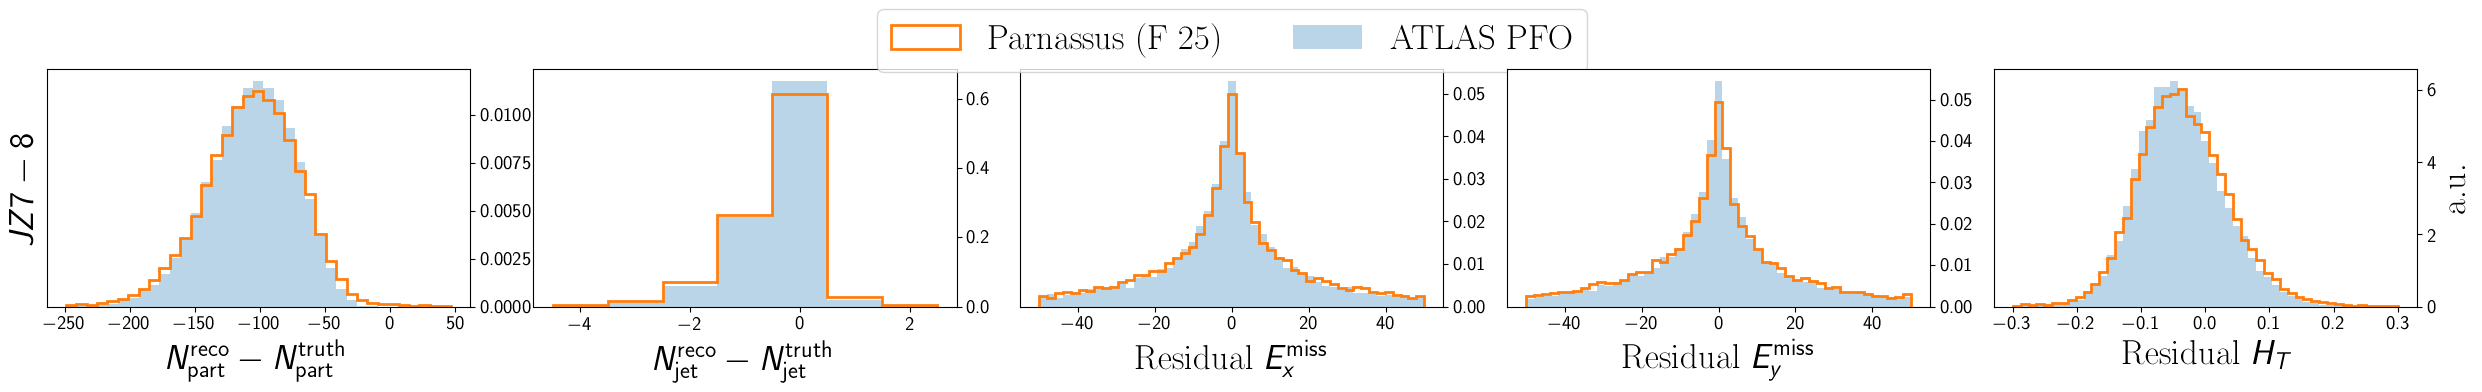

In [39]:
fig, ax = plt.subplots(num_samples, 5, figsize=(25, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        value = samples_data[sample]["all"][key]
        value_truth = samples_data[sample]["all"]["tr"]
        value['n_part_res'] = (value[card_varnames[key]] - value_truth[card_varnames['tr']])
        value["n_jets_res"] = (value["n_jets"] - value_truth["n_jets"]) 
        value["met_x_res"] = (value["met_x"] - value_truth["met_x"]) / value_truth[
            "met_x"
        ]
        value["met_y_res"] = (value["met_y"] - value_truth["met_y"]) / value_truth[
            "met_y"
        ]
        value["ht_res"] = (value["ht"] - value_truth["ht"]) / value_truth["ht"]
        for j, var in enumerate(["n_part_res", "n_jets_res", "met_x_res", "met_y_res", "ht_res"]):
            ax[i, j].hist(
                value[var],
                bins=res_bins_dict[var] if var not in ["met_x_res", "met_y_res", "ht_res"] else res_bins_dict[var][sample],
                **settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",
            )


    for j in range(5):
        ax[i, j].yaxis.tick_right()
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [
                    r"$N_{\mathrm{part}}^{\mathrm{reco}} - N_{\mathrm{part}}^{\mathrm{truth}}$",
                    r"$N_{\mathrm{jet}}^{\mathrm{reco}} - N_{\mathrm{jet}}^{\mathrm{truth}}$",
                    r"Residual $E_{x}^{\mathrm{miss}}$",
                    r"Residual $E_{y}^{\mathrm{miss}}$",
                    r"Residual $H_T$",
                ][j],
                fontsize=25,
            )
    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, 4].set_ylabel("a.u.", fontsize=25)
    ax[i, 4].yaxis.set_label_position("right")

ax[0, 2].legend(
    loc="upper center", ncol=5, fancybox=True, fontsize=25, bbox_to_anchor=(0.5, 1.325)
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.15)
# fig.suptitle("Event level residuals", fontsize=40, y=1.025)
plt.show()

#### Jet-level plots

In [40]:
def get_jet_features_dict(data):
    return {
        "pt": data["jets_pt"],
        "eta": data["jets_eta"],
        "phi": reshape_phi(data["jets_phi"]),
        "d2": np.array([np.log(el + 1e-9) for el in data["jets_d2"]], dtype=object),
        "c2": data["jets_c2"],
        "idx": data[
            "jets_pt"
        ],  # fake, not used, serves for compatibility with "matching" function
    }

In [41]:
def get_leading_jet_features_dict(data):
    return {
        "pt": np.array(
            [el[0] for el in data["jets_pt"] if len(el) > 0], dtype=np.float32
        ),
        "eta": np.array(
            [el[0] for el in data["jets_eta"] if len(el) > 0], dtype=np.float32
        ),
        "phi": np.array(
            [el[0] for el in reshape_phi(data["jets_phi"]) if len(el) > 0],
            dtype=np.float32,
        ),
        "d2": np.array(
            [np.log(el[0] + 1e-9) for el in data["jets_d2"] if len(el) > 0],
            dtype=np.float32,
        ),
        "c2": np.array(
            [el[0] for el in data["jets_c2"] if len(el) > 0], dtype=np.float32
        ),
        "idx": np.array(
            [el[0] for el in data["jets_pt"] if len(el) > 0], dtype=np.float32
        ),
    }

In [42]:
jet_dicts = {key: {} for key in samples_data.keys()}
for sample in samples_data.keys():
    for key in samples_data[sample]["jet"].keys():
        jet_dicts[sample][key] = get_jet_features_dict(samples_data[sample]["all"][key])

In [43]:
leading_jet_dicts = {key: {} for key in samples_data.keys()}
for sample in samples_data.keys():
    for key in samples_data[sample]["jet"].keys():
        leading_jet_dicts[sample][key] = get_leading_jet_features_dict(
            samples_data[sample]["all"][key]
        )

In [44]:
jet_matching_dicts = {key: {} for key in samples_data.keys()}

In [45]:
for sample in samples_data.keys():
    for key in samples_data[sample]["jet"].keys():
        if key == 'tr':
            continue
        jet_matching_dicts[sample][key] = matching(
            jet_dicts[sample][key], jet_dicts[sample]["tr"], dr_match=True, dr_cut=0.2
        )

matching: 100%|██████████| 19266/19266 [00:02<00:00, 8992.14it/s]


Matching done!


matching: 100%|██████████| 19266/19266 [00:02<00:00, 8957.97it/s]

Matching done!


In [46]:
jet_res_dicts = {key: {} for key in samples_data.keys()}
for sample in samples_data.keys():
    for key in samples_data[sample]["jet"].keys():
        if key == 'tr':
            continue
        jet_res_dicts[sample][key] = calc_jet_residuals(
            jet_matching_dicts[sample][key][0],
            jet_matching_dicts[sample][key][1],
            jet_dicts[sample][key],
            jet_dicts[sample]["tr"],
        )

residuals: 100%|██████████| 19266/19266 [00:00<00:00, 112421.83it/s]


In [47]:
def get_leading_jet_res_dict(data, key):
    varlist = ["pt", "eta", "phi", "c2", "d2"]
    res = {var: [] for var in varlist}
    for var in varlist:
        for tr_, fs_ in zip(data["tr"][f"jets_{var}"], data[key][f"jets_{var}"]):
            if len(tr_) > 0 and len(fs_) > 0:
                if var == "d2":
                    res[var].append(np.log(fs_[0] + 1e-9) - np.log(tr_[0] + 1e-9))
                elif var == "phi":
                    tr_phi = reshape_phi(tr_)
                    fs_phi = reshape_phi(fs_)
                    res[var].append(fs_phi[0] - tr_phi[0])
                elif var == "pt":
                    res[var].append((tr_[0] - fs_[0]) / tr_[0])
                else:
                    res[var].append(tr_[0] - fs_[0])
        res[var] = np.array(res[var], dtype=np.float32)
    return res

In [48]:
leading_jet_res_dicts = {key: {} for key in samples_data.keys()}
for sample in samples_data.keys():
    for key in samples_data[sample]["jet"].keys():
        if key == 'tr':
            continue
        leading_jet_res_dicts[sample][key] = get_leading_jet_res_dict(
            samples_data[sample]["all"], key
        )

In [49]:
bins_jet_res = {
    "pt": defaultdict(constant_factory(np.linspace(-1, 1, 50))),
    "eta": defaultdict(constant_factory(np.linspace(-0.1, 0.1, 50))),
    "phi": defaultdict(constant_factory(np.linspace(-0.1, 0.1, 50))),
    "d2": defaultdict(constant_factory(np.linspace(-1.2, 0.8, 50))),
    "c2": defaultdict(constant_factory(np.linspace(-0.2, 0.2, 50))),
}
# bins_jet_res["pt"].update(
#     {
#         "JZ3456": np.linspace(-0.4, 0.4, 50),
#     }
# )
# bins_jet_res["eta"].update(
#     {
#         "JZ3456": np.linspace(-0.02, 0.02, 50),
#     }
# )
# bins_jet_res["phi"].update(
#     {
#         "JZ3456": np.linspace(-0.02, 0.02, 50),
#     }
# )

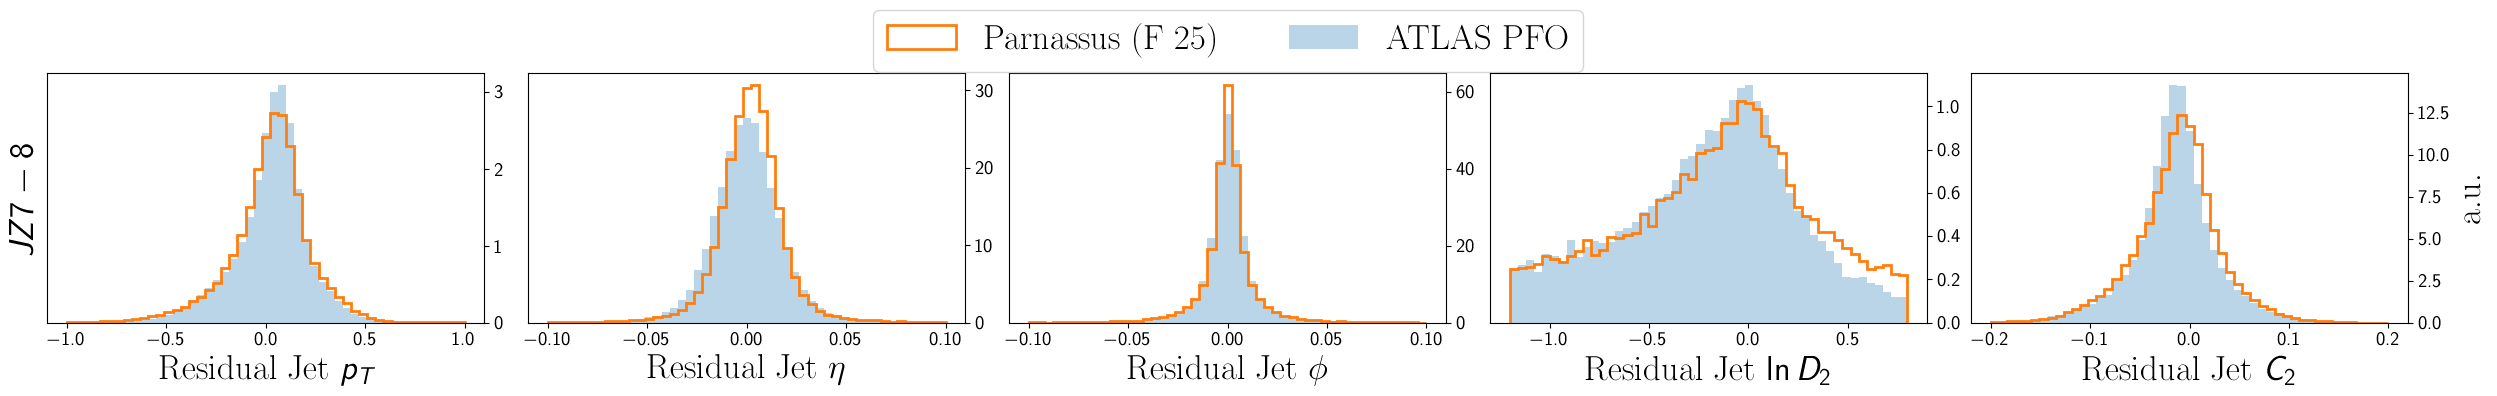

In [50]:
fig, ax = plt.subplots(num_samples, 5, figsize=(25, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    # for key in ["pf", "fm", "df", "dl"]:
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        value = jet_res_dicts[sample][key]
        for j, var in enumerate(["pt", "eta", "phi", "d2", "c2"]):
            ax[i, j].hist(
                # jet_res_dicts[sample][key][var],
                jet_res_dicts[sample][key][var]
                if var not in ["d2", "c2"]
                else leading_jet_res_dicts[sample][key][var],
                bins=bins_jet_res[var][sample],
                **settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",
            )
    for j in range(5):
        ax[i, j].yaxis.tick_right()
        # ax[i, j].set_title(f"{sample} sample")
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [
                    r"Residual Jet $p_T$",
                    r"Residual Jet $\eta$",
                    r"Residual Jet $\phi$",
                    r"Residual Jet $\ln{D_2}$",
                    r"Residual Jet $C_2$",
                ][j],
                fontsize=25,
            )
    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, 4].set_ylabel("a.u.", fontsize=25)
    ax[i, 4].yaxis.set_label_position("right")

ax[0, 2].legend(
    loc="upper center", ncol=5, fancybox=True, fontsize=25, bbox_to_anchor=(0.5, 1.325)
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
# fig.suptitle("Event level residuals", fontsize=40, y=1.025)
plt.show()

#### Particle-level plots

In [51]:
bins_1d = {
    "pt": np.linspace(0, 200, 100),
    "eta": np.linspace(-2.7, 2.7, 100),
    "phi": np.linspace(-np.pi, np.pi, 100),
    "vx": np.linspace(-2, 2, 100),
    "vy": np.linspace(-2, 2, 100),
    "vz": np.linspace(-20, 20, 100),
}

##### All particles

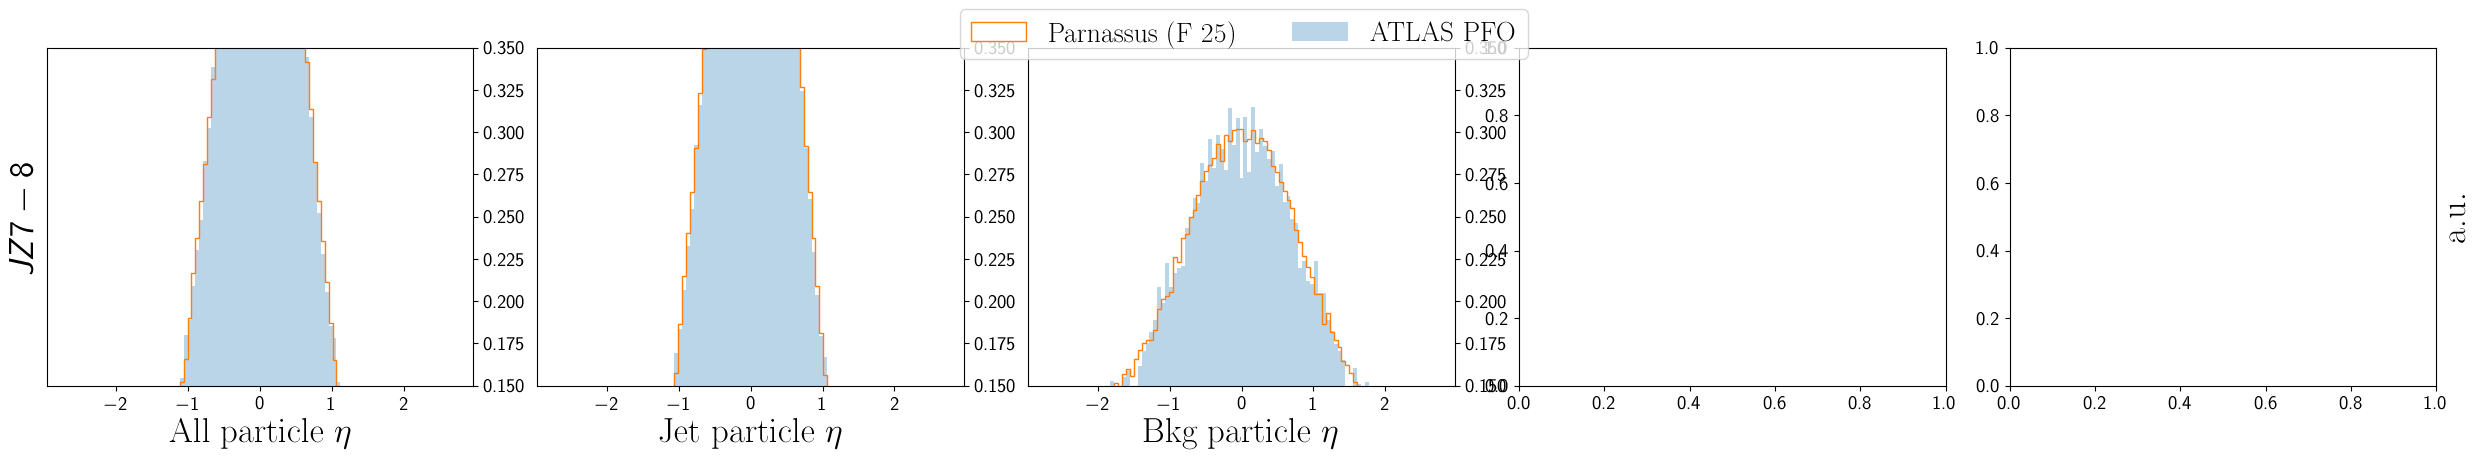

In [52]:
fig, ax = plt.subplots(num_samples, 5, figsize=(25, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        for j, split in enumerate(["all", "jet", "bkg"]):
            value = np.concatenate(samples_data[sample][split][key]['eta'])
            ax[i, j].hist(
                value, bins=np.linspace(-2.7, 2.7, 100),
                **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",
            )

    for j in range(3):
        ax[i, j].yaxis.tick_right()
        ax[i, j].set_ylim(0.15, 0.35)
        if i > 0 and j == 1:
            ax[i, j].set_ylim(0.0, 0.4)
        # ax[i, j].set_title(f"{sample} sample")
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [
                    r"All particle $\eta$",
                    r"Jet particle $\eta$",
                    r"Bkg particle $\eta$",
                ][j],
                fontsize=25,
            )
    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, -1].set_ylabel("a.u.", fontsize=25)
    ax[i, -1].yaxis.set_label_position("right")
h, l = ax[0, 0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=20,
    bbox_to_anchor=(0.5, 1.055),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

##### Residuals all particles

In [53]:
particle_matching_dicts = {key: {} for key in samples_data.keys()}
particle_matching_dicts_jet = {key: {} for key in samples_data.keys()}
particle_matching_dicts_bkg = {key: {} for key in samples_data.keys()}

In [54]:
import pickle

In [55]:
with open(
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ3456_84_25_45k_test_eta25Eval_particle_matching_dicts_all.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZall_65_25_154k_test_eta25Eval_particle_matching_dicts_all.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ7-8_65_25_19k_test_eta25Eval_particle_matching_dicts_all.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ1-2_65_25_99k_test_eta25Eval_particle_matching_dicts_all.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ3-6_65_25_45k_test_eta25Eval_particle_matching_dicts_all.pkl",
    "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ78_196_25_19k_test_eta25Eval_particle_matching_dicts_all.pkl",
    "rb",
) as f:
    particle_matching_dicts = pickle.load(f)
with open(
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ3456_84_25_45k_test_eta25Eval_particle_matching_dicts_jet.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZall_65_25_154k_test_eta25Eval_particle_matching_dicts_jet.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ7-8_65_25_19k_test_eta25Eval_particle_matching_dicts_jet.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ1-2_65_25_99k_test_eta25Eval_particle_matching_dicts_jet.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ3-6_65_25_45k_test_eta25Eval_particle_matching_dicts_jet.pkl",
    "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ78_196_25_19k_test_eta25Eval_particle_matching_dicts_jet.pkl",
    "rb",
) as f:
    particle_matching_dicts_jet = pickle.load(f)
with open(
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ3456_84_25_45k_test_eta25Eval_particle_matching_dicts_bkg.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZall_65_25_154k_test_eta25Eval_particle_matching_dicts_bkg.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ7-8_65_25_19k_test_eta25Eval_particle_matching_dicts_bkg.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ1-2_65_25_99k_test_eta25Eval_particle_matching_dicts_bkg.pkl",
    # "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ3-6_65_25_45k_test_eta25Eval_particle_matching_dicts_bkg.pkl",
    "/storage/agrp/dreyet/f_delphes/cms-flow-evt/evals/rcfm_atlas_part_JZ78_196_25_19k_test_eta25Eval_particle_matching_dicts_bkg.pkl",
    "rb",
) as f:
    particle_matching_dicts_bkg = pickle.load(f)

In [56]:
particle_res_dicts = {key: {} for key in samples_data.keys()}
particle_res_dicts_jet = {key: {} for key in samples_data.keys()}
particle_res_dicts_bkg = {key: {} for key in samples_data.keys()}

In [57]:
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        particle_res_dicts[sample][key] = calc_residuals(
            particle_matching_dicts[sample][key][1],
            particle_matching_dicts[sample][key][0],
            samples_data[sample]["all"][key],
            samples_data[sample]["all"]["tr"],
        )
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        particle_res_dicts_jet[sample][key] = calc_residuals(
            particle_matching_dicts_jet[sample][key][1],
            particle_matching_dicts_jet[sample][key][0],
            samples_data[sample]["jet"][key],
            samples_data[sample]["jet"]["tr"],
        )
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        particle_res_dicts_bkg[sample][key] = calc_residuals(
            particle_matching_dicts_bkg[sample][key][1],
            particle_matching_dicts_bkg[sample][key][0],
            samples_data[sample]["bkg"][key],
            samples_data[sample]["bkg"]["tr"],
        )

Processing... JZ7-8 sample


residuals:   0%|          | 0/19266 [00:00<?, ?it/s]

residuals: 100%|██████████| 19266/19266 [00:00<00:00, 113485.81it/s]


Processing... JZ7-8 sample


residuals: 100%|██████████| 19266/19266 [00:00<00:00, 122919.03it/s]


Processing... JZ7-8 sample


residuals: 100%|██████████| 19266/19266 [00:00<00:00, 158467.75it/s]


In [58]:
bins_res = {
    "pt": np.linspace(-1, 1, 50),
    "eta": np.linspace(-0.5, 0.5, 50),
    "phi": np.linspace(-0.5, 0.5, 50),
    # "vx": np.linspace(-0.5, 0.5, 50),
    # "vy": np.linspace(-0.5, 0.5, 50),
    # "vz": np.linspace(-0.5, 0.5, 50),
}

num_particle_features = len(bins_res)

##### All particles

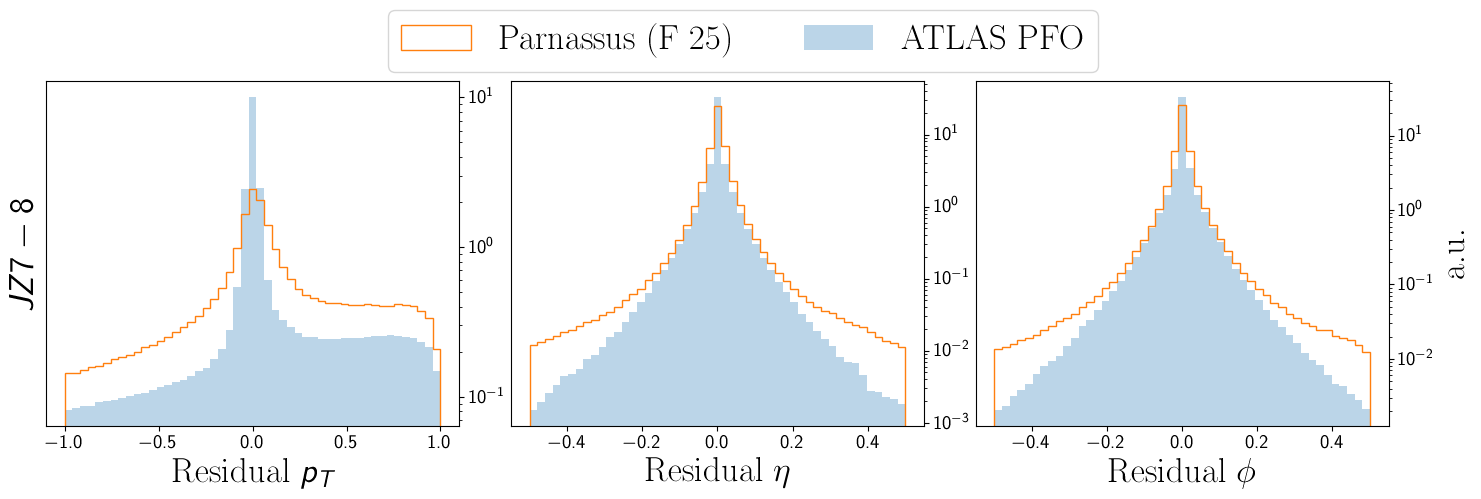

In [59]:
fig, ax = plt.subplots(num_samples, num_particle_features, figsize=(5*num_particle_features, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        for j, var in enumerate(["pt", "eta", "phi"]): #, "vx", "vy", "vz"]):
            value = particle_res_dicts[sample][key][var]
            ax[i, j].hist(
                value, 
                bins=bins_res[var],
                **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",              
            )
    for j in range(num_particle_features):
        ax[i, j].set_yscale("log")
        ax[i, j].yaxis.tick_right()
        # ax[i, j].set_title(f"{sample} sample")
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [
                    r"Residual $p_T$",
                    r"Residual $\eta$",
                    r"Residual $\phi$",
                    # r"Residual $v_x$",
                    # r"Residual $v_y$",
                    # r"Residual $v_z$",
                ][j],
                fontsize=25,
            )

    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, num_particle_features - 1].set_ylabel("a.u.", fontsize=25)
    ax[i, num_particle_features - 1].yaxis.set_label_position("right")
h, l = ax[0, 0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.125)
plt.show()

In [60]:
# fig.savefig("fevt_paper_plots/all_part_res.pdf", dpi=300, bbox_inches="tight")

##### Jet particles

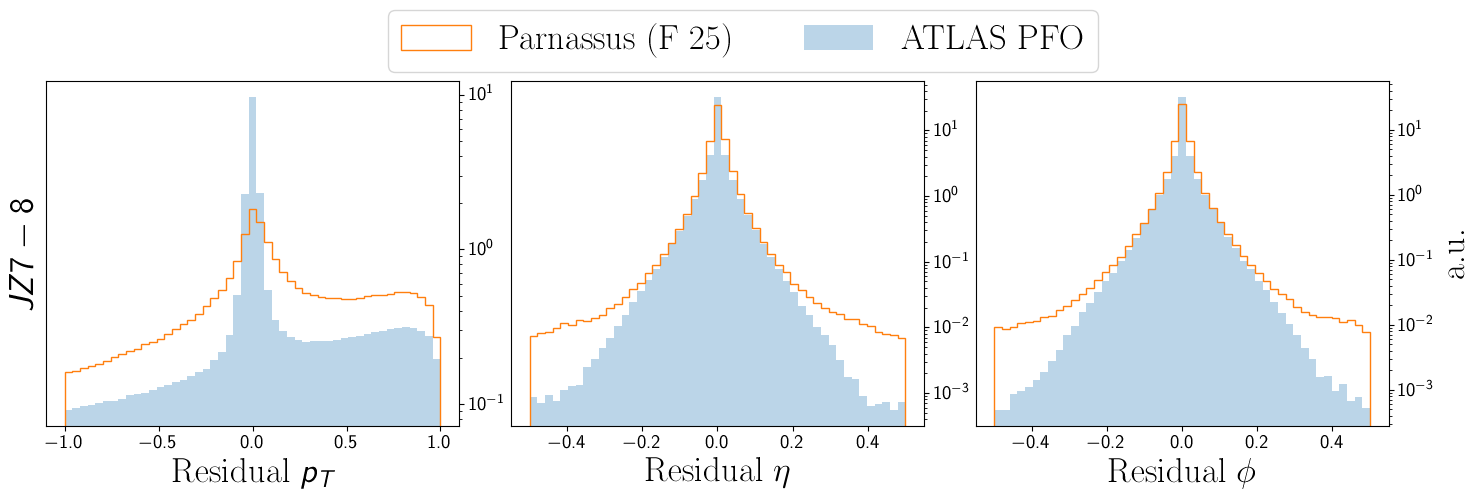

In [61]:
fig, ax = plt.subplots(num_samples, num_particle_features, figsize=(5*num_particle_features, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        for j, var in enumerate(["pt", "eta", "phi"]): #, "vx", "vy", "vz"]):
            value = particle_res_dicts_jet[sample][key][var]
            ax[i, j].hist(
                value, 
                bins=bins_res[var],
                **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",              
            )

    for j in range(num_particle_features):
        ax[i, j].set_yscale("log")
        ax[i, j].yaxis.tick_right()
        # ax[i, j].set_title(f"{sample} sample")
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [
                    r"Residual $p_T$",
                    r"Residual $\eta$",
                    r"Residual $\phi$",
                    r"Residual $v_x$",
                    r"Residual $v_y$",
                    r"Residual $v_z$",
                ][j],
                fontsize=25,
            )

    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, num_particle_features - 1].set_ylabel("a.u.", fontsize=25)
    ax[i, num_particle_features - 1].yaxis.set_label_position("right")
h, l = ax[0, 0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.125)
plt.show()

In [62]:
# fig.savefig("fevt_paper_plots/jet_part_res.pdf", dpi=300, bbox_inches="tight")

##### Bkg particles

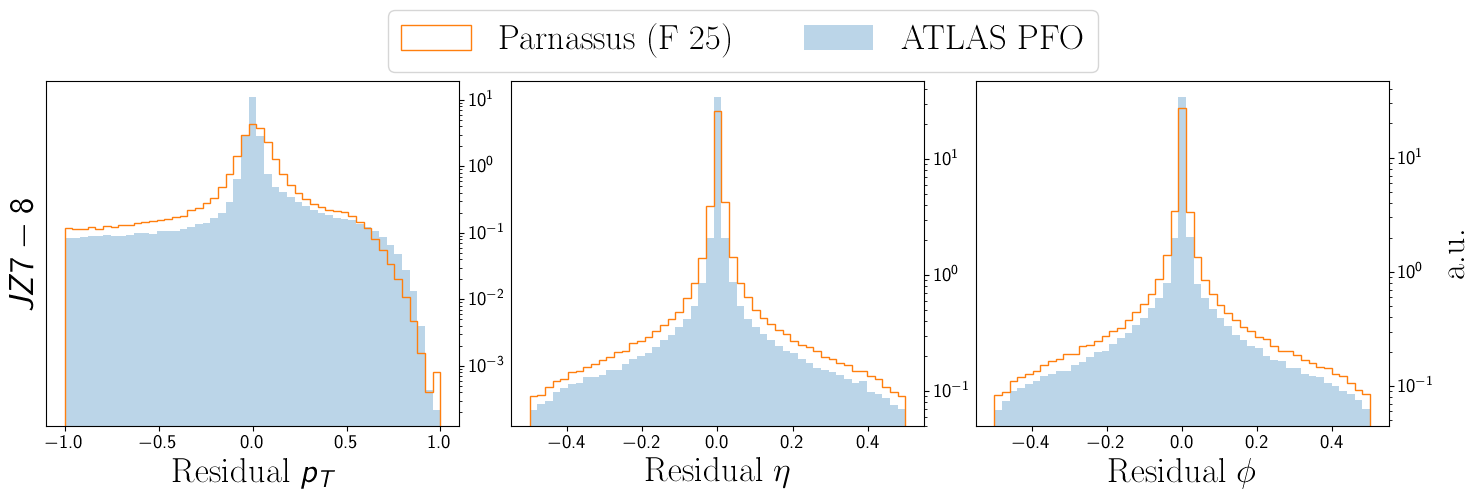

In [63]:
fig, ax = plt.subplots(num_samples, num_particle_features, figsize=(5*num_particle_features, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        for j, var in enumerate(["pt", "eta", "phi"]): #, "vx", "vy", "vz"]):
            value = particle_res_dicts_bkg[sample][key][var]
            ax[i, j].hist(
                value, 
                bins=bins_res[var],
                **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",              
            )

    for j in range(num_particle_features):
        ax[i, j].set_yscale("log")
        ax[i, j].yaxis.tick_right()
        # ax[i, j].set_title(f"{sample} sample")
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [
                    r"Residual $p_T$",
                    r"Residual $\eta$",
                    r"Residual $\phi$",
                    r"Residual $v_x$",
                    r"Residual $v_y$",
                    r"Residual $v_z$",
                ][j],
                fontsize=25,
            )

    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, num_particle_features - 1].set_ylabel("a.u.", fontsize=25)
    ax[i, num_particle_features - 1].yaxis.set_label_position("right")
h, l = ax[0, 0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.125)
plt.show()

In [64]:
# fig.savefig("fevt_paper_plots/bkg_part_res.pdf", dpi=300, bbox_inches="tight")

##### Unmatched particles

In [ ]:
def get_unmatched_data(data, indices):
    varlist = ["pt", "eta", "phi"] #, "vx", "vy", "vz"]
    unmatched_data = {var: [] for var in varlist}
    idxs = np.arange(400)
    for i in range(len(data["pt"])):
        not_matched = np.setdiff1d(idxs[: len(data["pt"][i])], indices[i])
        for var in varlist:
            unmatched_data[var].append(data[var][i][not_matched])
    return unmatched_data

In [ ]:
unmatched_data_dicts = {key: {} for key in samples_data.keys()}
unmatched_data_dicts_jet = {key: {} for key in samples_data.keys()}
unmatched_data_dicts_bkg = {key: {} for key in samples_data.keys()}

In [ ]:
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        unmatched_data_dicts[sample][key] = get_unmatched_data(
            samples_data[sample]["all"][key],
            particle_matching_dicts[sample][key][0],
        )
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        unmatched_data_dicts_jet[sample][key] = get_unmatched_data(
            samples_data[sample]["jet"][key],
            particle_matching_dicts_jet[sample][key][0],
        )
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        unmatched_data_dicts_bkg[sample][key] = get_unmatched_data(
            samples_data[sample]["bkg"][key],
            particle_matching_dicts_bkg[sample][key][0],
        )

Processing... JZ3-6 sample
Processing... JZ3-6 sample
Processing... JZ3-6 sample


In [ ]:
bins_1d = {
    "pt": defaultdict(constant_factory(np.linspace(0, 600, 200))),
    "eta": defaultdict(constant_factory(np.linspace(-2.7, 2.7, 100))),
    "phi": defaultdict(constant_factory(np.linspace(-np.pi, np.pi, 100))),
    # "vx": defaultdict(constant_factory(np.linspace(-2, 2, 100))),
    # "vy": defaultdict(constant_factory(np.linspace(-2, 2, 100))),
    # "vz": defaultdict(constant_factory(np.linspace(-20, 20, 100))),
}
# bins_1d["pt"].update(
#     {
#         "h4lep": np.linspace(0, 30, 100),
#         "ttbar": np.linspace(0, 30, 100),
#     }
# )

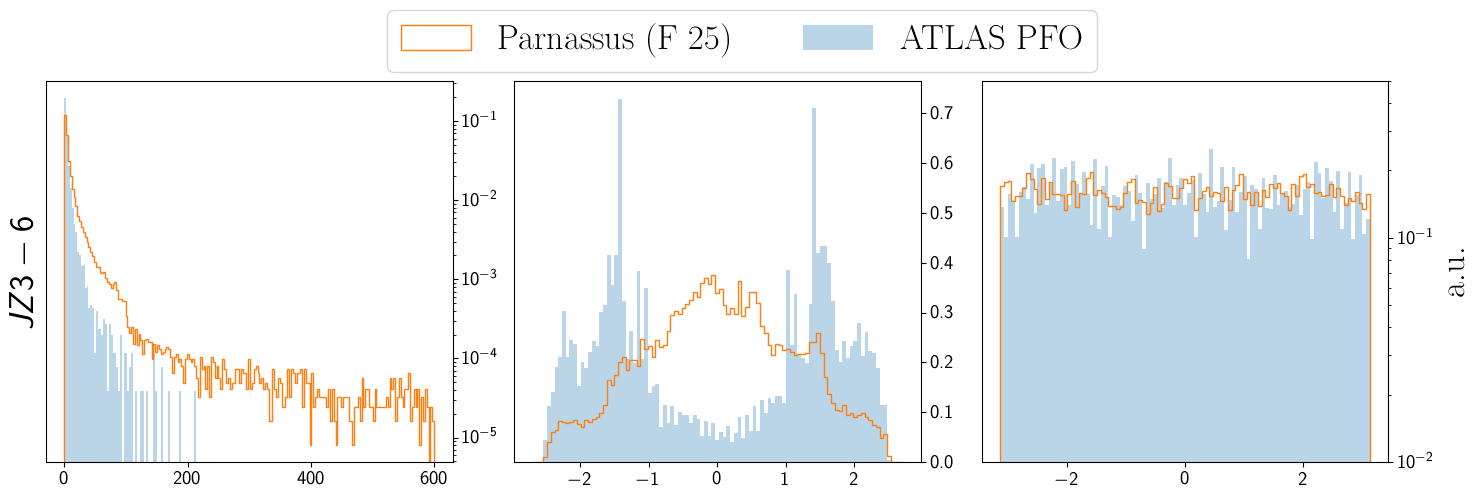

In [ ]:
fig, ax = plt.subplots(num_samples, num_particle_features, figsize=(5*num_particle_features, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        for j, var in enumerate(["pt", "eta", "phi"]): #, "vx", "vy", "vz"]):
            value = np.concatenate(unmatched_data_dicts[sample][key][var])
            ax[i, j].hist(
                value, 
                bins=bins_1d[var][sample],
                **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",              
            )

    for j in range(num_particle_features):
        if j != 1:
            ax[i, j].set_yscale("log")
        ax[i, j].yaxis.tick_right()
        # ax[i, j].set_title(f"{sample} sample")
        if i == 3:
            ax[i, j].set_xlabel(
                [r"$p_T$, GeV", r"$\eta$", r"$\phi$", r"$v_x$", r"$v_y$", r"$v_z$"][j],
                fontsize=25,
            )
    ax[i, 2].set_ylim(1e-2, 0.5)
    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, num_particle_features - 1].set_ylabel("a.u.", fontsize=25)
    ax[i, num_particle_features - 1].yaxis.set_label_position("right")
h, l = ax[0, 0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

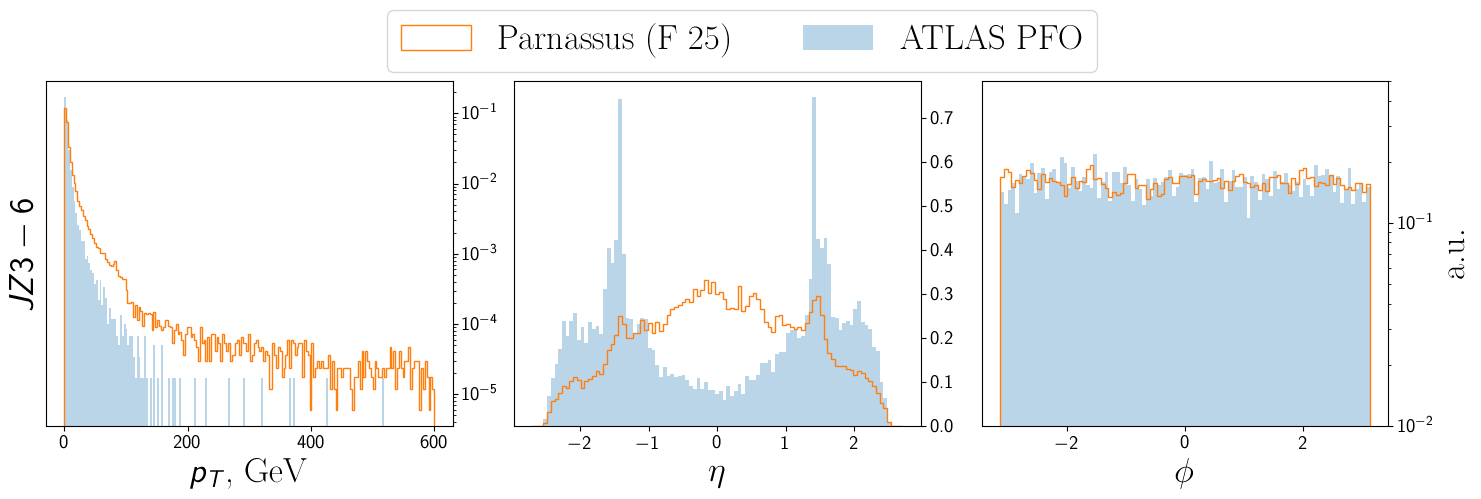

In [ ]:
fig, ax = plt.subplots(num_samples, num_particle_features, figsize=(5*num_particle_features, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        for j, var in enumerate(["pt", "eta", "phi"]): #, "vx", "vy", "vz"]):
            value = np.concatenate(unmatched_data_dicts_jet[sample][key][var])
            ax[i, j].hist(
                value, 
                bins=bins_1d[var][sample],
                **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",              
            )

    for j in range(num_particle_features):
        if j != 1:
            ax[i, j].set_yscale("log")
        ax[i, j].yaxis.tick_right()
        # ax[i, j].set_title(f"{sample} sample")
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [r"$p_T$, GeV", r"$\eta$", r"$\phi$", r"$v_x$", r"$v_y$", r"$v_z$"][j],
                fontsize=25,
            )
    ax[i, 2].set_ylim(1e-2, 0.5)
    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, num_particle_features - 1].set_ylabel("a.u.", fontsize=25)
    ax[i, num_particle_features - 1].yaxis.set_label_position("right")
h, l = ax[0, 0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

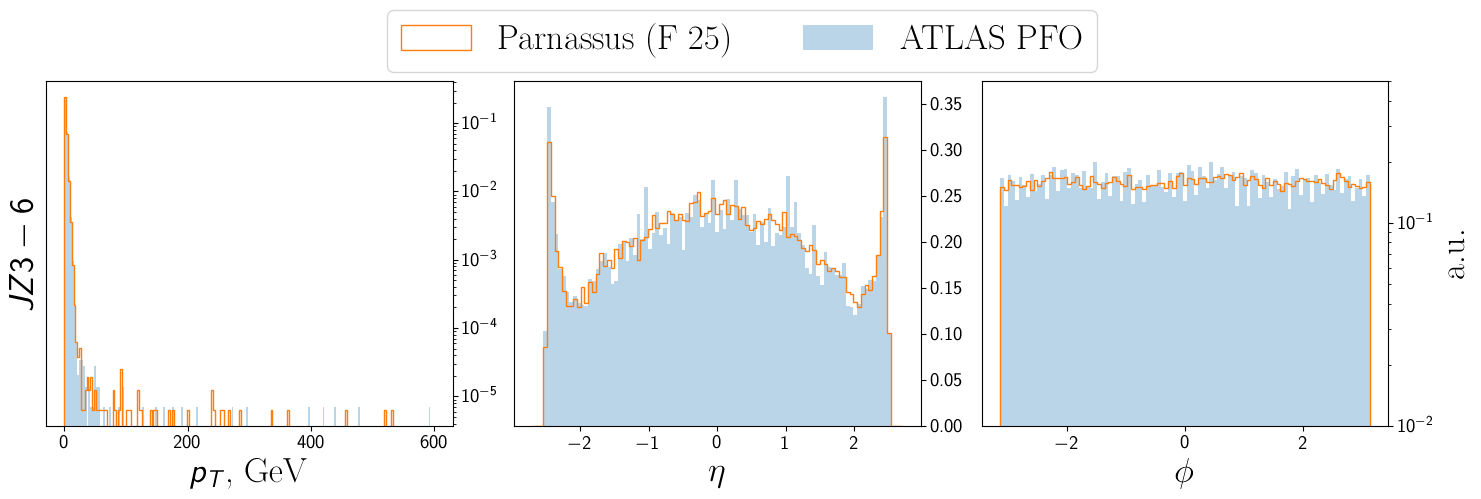

In [ ]:
fig, ax = plt.subplots(num_samples, num_particle_features, figsize=(5*num_particle_features, 4.5*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for key in [*fms, 'pf']:
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        for j, var in enumerate(["pt", "eta", "phi"]): #, "vx", "vy", "vz"]):
            value = np.concatenate(unmatched_data_dicts_bkg[sample][key][var])
            ax[i, j].hist(
                value, 
                bins=bins_1d[var][sample],
                **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
                density=True,
                histtype="stepfilled" if key == "pf" else "step",              
            )

    for j in range(num_particle_features):
        if j != 1:
            ax[i, j].set_yscale("log")
        ax[i, j].yaxis.tick_right()
        # ax[i, j].set_title(f"{sample} sample")
        if i == num_samples - 1:
            ax[i, j].set_xlabel(
                [r"$p_T$, GeV", r"$\eta$", r"$\phi$", r"$v_x$", r"$v_y$", r"$v_z$"][j],
                fontsize=25,
            )
    ax[i, 2].set_ylim(1e-2, 0.5)
    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.05, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

    ax[i, num_particle_features - 1].set_ylabel("a.u.", fontsize=25)
    ax[i, num_particle_features - 1].yaxis.set_label_position("right")
h, l = ax[0, 0].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

In [ ]:
# fig.savefig("fevt_paper_plots/unmatch_part.pdf", dpi=300, bbox_inches="tight")

##### Class plots

In [ ]:
classes_dicts = {key: {} for key in samples_data.keys()}
classes_dicts_jet = {key: {} for key in samples_data.keys()}
classes_dicts_bkg = {key: {} for key in samples_data.keys()}

In [ ]:
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        classes_dicts[sample][key] = get_classes(
            particle_matching_dicts[sample][key][1],
            particle_matching_dicts[sample][key][0],
            samples_data[sample]["all"][key],
            samples_data[sample]["all"]["tr"],
        )
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        classes_dicts_jet[sample][key] = get_classes(
            particle_matching_dicts_jet[sample][key][1],
            particle_matching_dicts_jet[sample][key][0],
            samples_data[sample]["jet"][key],
            samples_data[sample]["jet"]["tr"],
        )
for sample in samples_data.keys():
    print(f"Processing... {sample} sample")
    for key in samples_data[sample]["all"].keys():
        if key == 'tr':
            continue
        classes_dicts_bkg[sample][key] = get_classes(
            particle_matching_dicts_bkg[sample][key][1],
            particle_matching_dicts_bkg[sample][key][0],
            samples_data[sample]["bkg"][key],
            samples_data[sample]["bkg"]["tr"],
        )

Processing... JZ3-6 sample
Processing... JZ3-6 sample
Processing... JZ3-6 sample


In [ ]:
def plot_cm(
    ax,
    pf_class,
    tr_class,
    normalize="true",
    annot=True,
    xticklables="auto",
    yticklables="auto",
    annot_fs=16,
):
    class_labels = ["Ch. had", r"$e^{\pm}$", r"${\mu}^{\pm}$", "Nu. had", r"$\gamma$"]
    cm_pf = confusion_matrix(tr_class, pf_class, labels=range(5), normalize=normalize)
    df_cm = pd.DataFrame(cm_pf, index=class_labels, columns=class_labels)
    sns.heatmap(
        df_cm,
        annot=annot,
        ax=ax,
        cmap=sns.cubehelix_palette(start=0.5, rot=-0.5, as_cmap=True),
        fmt=".2f",
        cbar=False,
        annot_kws={"size": annot_fs},
        xticklabels=xticklables,
        yticklabels=yticklables,
    )

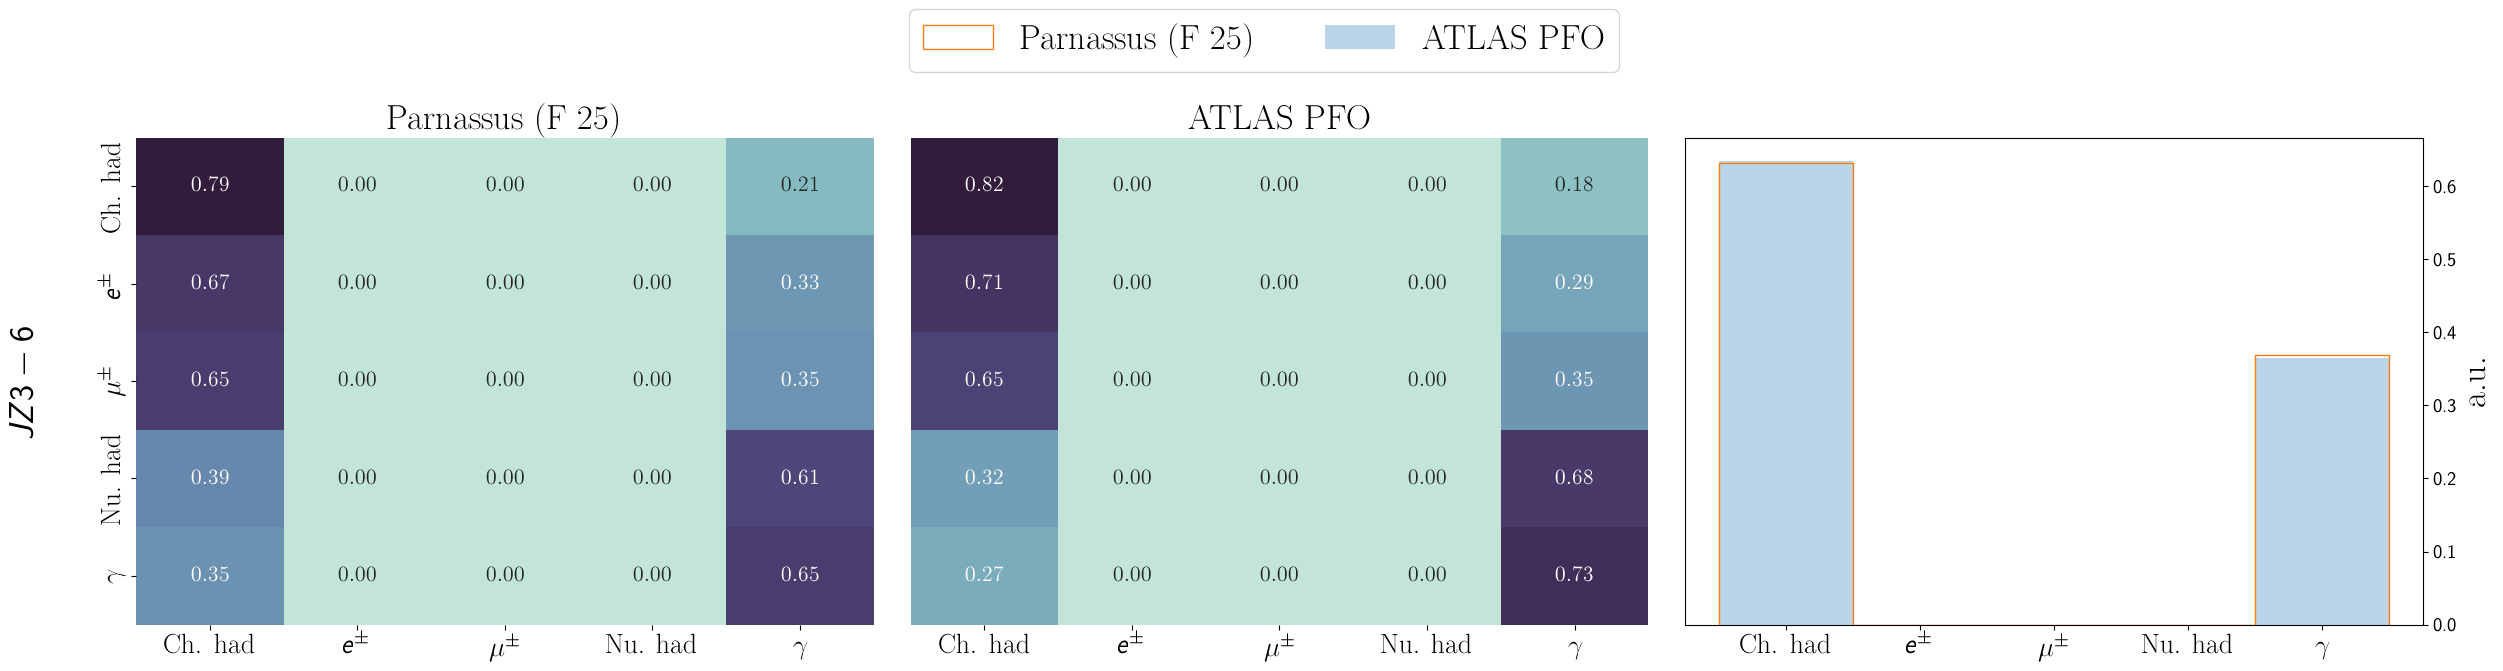

In [ ]:
fig, ax = plt.subplots(num_samples, len(fms) + 2, figsize=(25, 6*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for j, key in enumerate([*fms, 'pf']):
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        plot_cm(
            ax[i, j],
            classes_dicts[sample][key][1],
            classes_dicts[sample][key][0],
            yticklables="auto" if j == 0 else False,
            xticklables="auto" if i == num_samples - 1 else False,
        )
        ax[i, -1].hist(
            np.concatenate(samples_data[sample]["all"][key]["class"]),
            bins=np.arange(6) - 0.5,
            **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
            density=True,
            histtype="stepfilled" if key == "pf" else "step",
        )
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), fontsize=20)
        ax[i, j].set_yticklabels(ax[i, j].get_yticklabels(), fontsize=20)
        if i == 0:
            ax[i, j].set_title(settings_dict.get(key, {"label" : f"Parnassus (F {key[2:]})"})['label'], fontsize=25)
    ax[i, -1].set_ylabel("a.u.", fontsize=25)
    ax[i, -1].set_xticks(np.arange(5), [])
    ax[i, -1].yaxis.tick_right()
    ax[i, -1].yaxis.set_label_position("right")

    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.15, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

ax[num_samples - 1, -1].set_xticks(
    np.arange(5),
    ["Ch. had", r"$e^{\pm}$", r"${\mu}^{\pm}$", "Nu. had", r"$\gamma$"],
    fontsize=20,
)
h, l = ax[0, -1].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

In [ ]:
# fig.savefig("fevt_paper_plots/all_class.pdf", dpi=300, bbox_inches="tight")

In [ ]:
def get_class_probs(tr_classes, pf_classes, target_class=3):
    return pf_classes[
        tr_classes == target_class
    ]  # / np.sum(tr_classes == target_class)

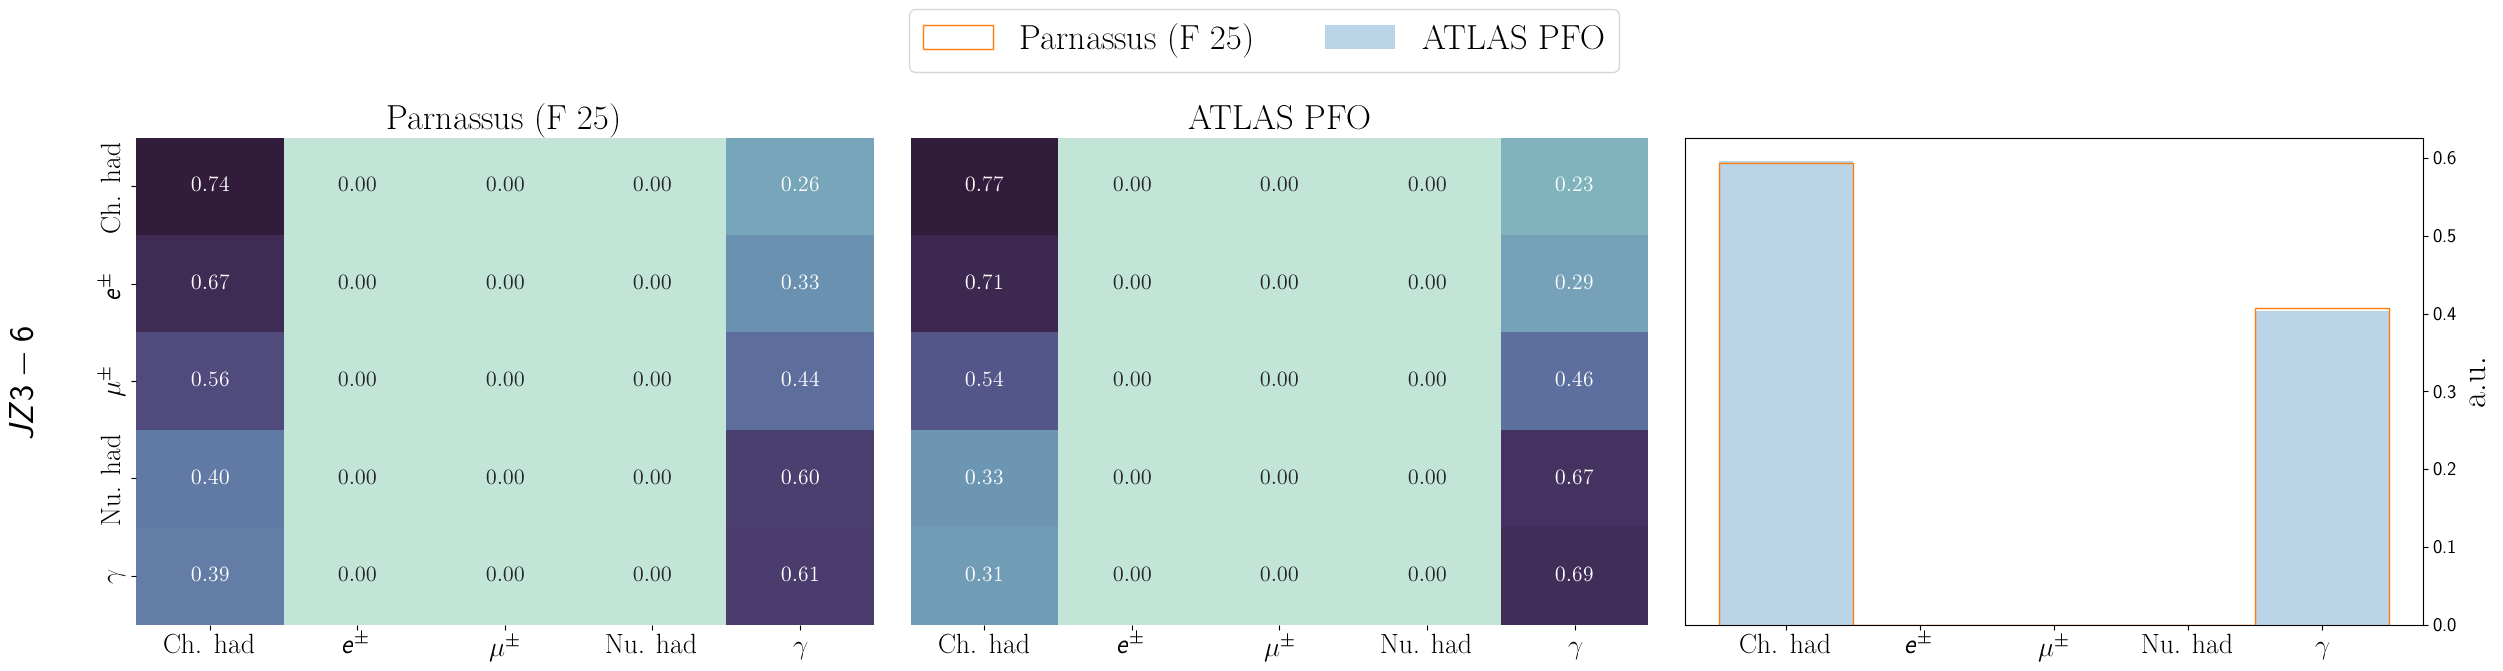

In [ ]:
fig, ax = plt.subplots(num_samples, len(fms) + 2, figsize=(25, 6*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for j, key in enumerate([*fms, 'pf']):
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        plot_cm(
            ax[i, j],
            classes_dicts_jet[sample][key][1],
            classes_dicts_jet[sample][key][0],
            yticklables="auto" if j == 0 else False,
            xticklables="auto" if i == num_samples - 1 else False,
        )
        ax[i, -1].hist(
            np.concatenate(samples_data[sample]["jet"][key]["class"]),
            bins=np.arange(6) - 0.5,
            **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
            density=True,
            histtype="stepfilled" if key == "pf" else "step",
        )
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), fontsize=20)
        ax[i, j].set_yticklabels(ax[i, j].get_yticklabels(), fontsize=20)
        if i == 0:
            ax[i, j].set_title(settings_dict.get(key, {"label" : f"Parnassus (F {key[2:]})"})['label'], fontsize=25)
    ax[i, -1].set_ylabel("a.u.", fontsize=25)
    ax[i, -1].set_xticks(np.arange(5), [])
    ax[i, -1].yaxis.tick_right()
    ax[i, -1].yaxis.set_label_position("right")

    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.15, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

ax[num_samples - 1, -1].set_xticks(
    np.arange(5),
    ["Ch. had", r"$e^{\pm}$", r"${\mu}^{\pm}$", "Nu. had", r"$\gamma$"],
    fontsize=20,
)
h, l = ax[0, -1].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

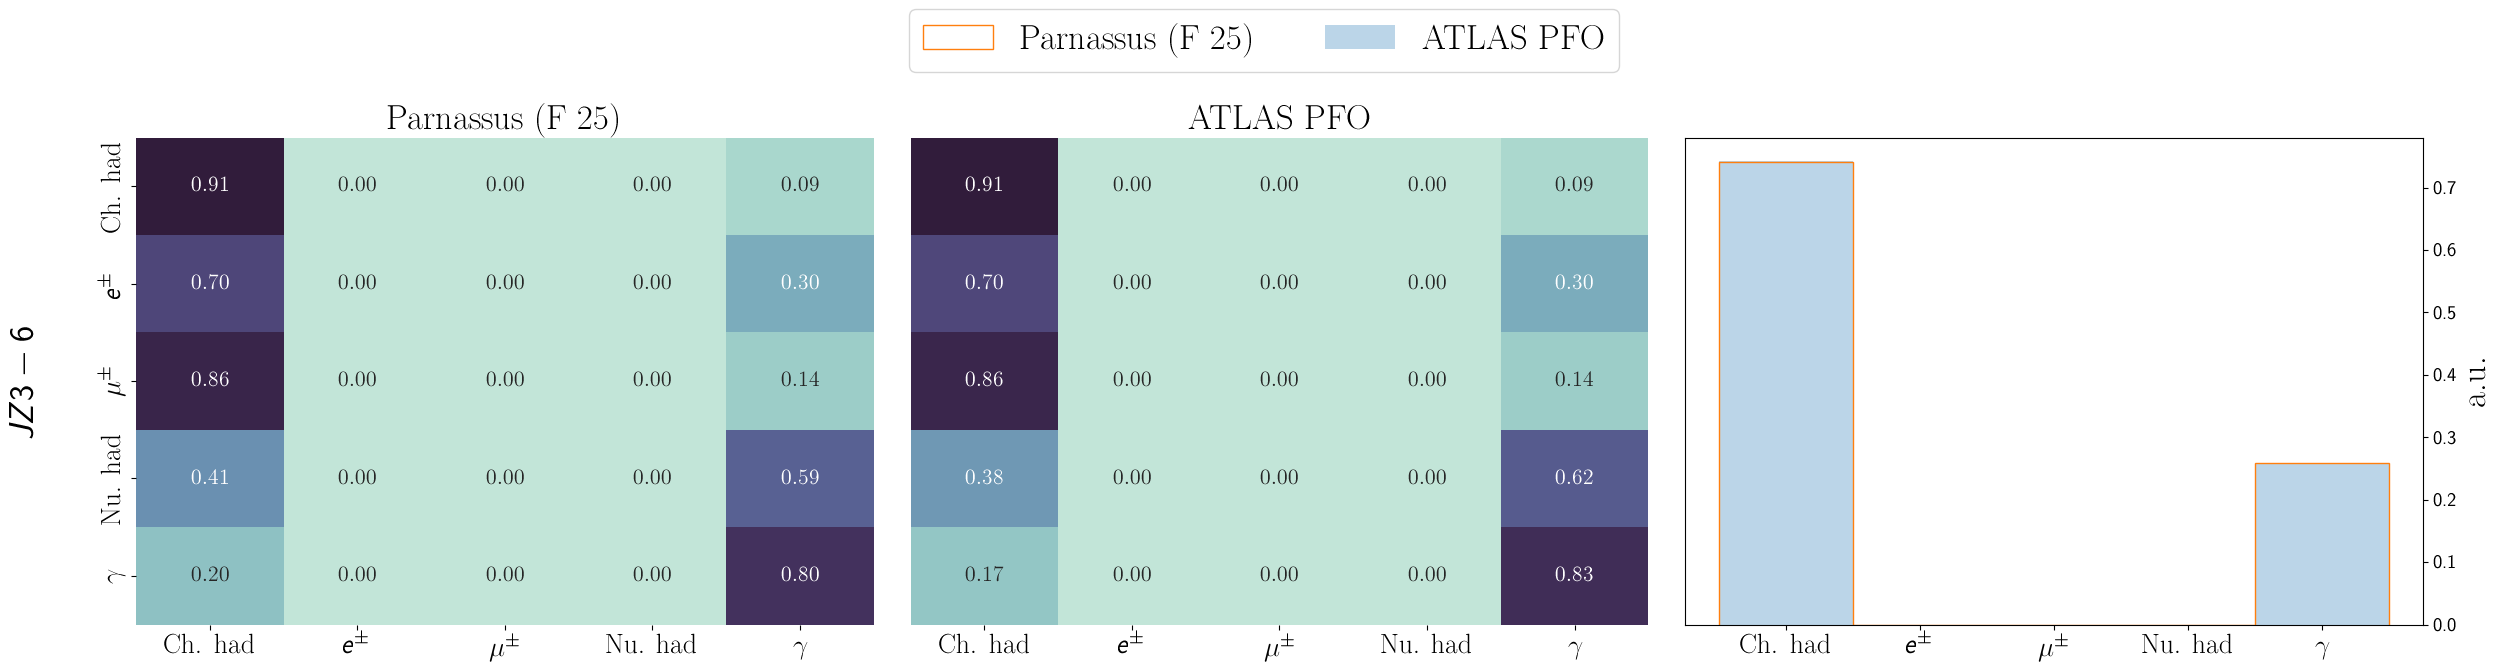

In [ ]:
fig, ax = plt.subplots(num_samples, len(fms) + 2, figsize=(25, 6*num_samples))
if num_samples == 1:
    ax = np.array([ax])

for i, sample in enumerate(samples_data.keys()):
    for j, key in enumerate([*fms, 'pf']):
        if 'fm' in key:
            good_color = good_colors[xbins.index(int(key[2:]))]
        plot_cm(
            ax[i, j],
            classes_dicts_bkg[sample][key][1],
            classes_dicts_bkg[sample][key][0],
            yticklables="auto" if j == 0 else False,
            xticklables="auto" if i == num_samples - 1 else False,
        )
        ax[i, -1].hist(
            np.concatenate(samples_data[sample]["bkg"][key]["class"]),
            bins=np.arange(6) - 0.5,
            **(settings_dict.get(key, settings_dict["fm"] | {"label": f"Parnassus (F {key[2:]})", "color" : good_color}) | {"linewidth" : 1}),
            density=True,
            histtype="stepfilled" if key == "pf" else "step",
        )
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), fontsize=20)
        ax[i, j].set_yticklabels(ax[i, j].get_yticklabels(), fontsize=20)
        if i == 0:
            ax[i, j].set_title(settings_dict.get(key, {"label" : f"Parnassus (F {key[2:]})"})['label'], fontsize=25)
    ax[i, -1].set_ylabel("a.u.", fontsize=25)
    ax[i, -1].set_xticks(np.arange(5), [])
    ax[i, -1].yaxis.tick_right()
    ax[i, -1].yaxis.set_label_position("right")

    ax[i, 0].annotate(
        sample_labels[sample],
        xy=(-0.15, 0.5),
        xycoords="axes fraction",
        fontsize=25,
        ha="center",
        va="center",
        rotation=90,
    )

ax[num_samples - 1, -1].set_xticks(
    np.arange(5),
    ["Ch. had", r"$e^{\pm}$", r"${\mu}^{\pm}$", "Nu. had", r"$\gamma$"],
    fontsize=20,
)
h, l = ax[0, -1].get_legend_handles_labels()
fig.legend(
    h,
    l,
    loc="upper center",
    ncol=5,
    fancybox=True,
    fontsize=25,
    bbox_to_anchor=(0.5, 1.15),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()